## Softmax
<p>We'll implement a 2D Softmax classifier. 
We'll build an image classification to identify to which number ( 0 - 9 ) an image corresponds.</p>
<ul>
    <li><a href="#data">Data: Images</a></li>
    <li><a href="#model">Create the Model and Loss function: Cross Entropy</a></li>
    <li><a href="#training">Training: Batch Gradient Descent</a></li>
    <li><a href="#results">Results</a></li>
</ul>

In [1]:
# !mamba install -y torchvision
#!pip install torchvision==0.9.1 torch==1.8.1 
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

In [2]:
# Helper functions
# Plotting parameters
def PlotParameters(model): 
    W = model.state_dict()['linear.weight'].data
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i < 10:
            
            # Set the label for the sub-plot.
            ax.set_xlabel("class: {0}".format(i))

            # Plot the image.
            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')

            ax.set_xticks([])
            ax.set_yticks([])

    plt.show()

In [3]:
# Helper function: data visualization
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

## <a name="data" id="data">Data: Images</a>

In [8]:
# Data will be downloaded as tensors
train_dataset = dsets.MNIST(root='/home/cristina/work/mine/coursera/pytorch_dnn/module2/data', train=True, download=True, transform=transforms.ToTensor())
validation_dataset = dsets.MNIST(root='/home/cristina/work/mine/coursera/pytorch_dnn/module2/data', train=True, download=True, transform=transforms.ToTensor())
# tuple (image, class)

In [13]:
print("Validation dataset info:\n ", validation_dataset)
print("Type of data element: ", type(validation_dataset[0][1]))

Validation dataset info:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/cristina/work/mine/coursera/pytorch_dnn/module2/data
    Split: Train
    StandardTransform
Transform: ToTensor()
Type of data element:  <class 'int'>


Each element in the rectangular tensor corresponds to a number that represents a pixel intensity. In the image the intensity values are inverted (i.e., black is white)
<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.32_image_values.png" width="550" alt="MNIST elements">


Example image:  None
Example label:  1


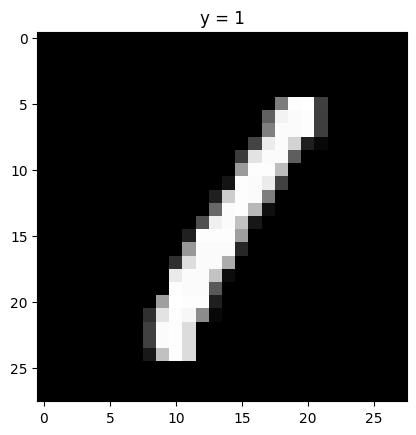

In [17]:
print("Example image: ", show_data(train_dataset[3]))
print("Example label: ", train_dataset[3][1])

## <a name="model" id="model">Model</a>

In [35]:
class SoftMax(nn.Module):
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        z = self.linear(x)
        return z

- input dimension = 28 x 28 - the image dimension. Flattened is 784 elements.
- likewise parameters will have the same size
- There will be 10 output classes: 0 - 9 number identification
        

In [36]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [37]:
# Set input size and output size
input_dim = 28 * 28
output_dim = 10

In [38]:
# Softmax classifier and parameters
model = SoftMax(input_dim, output_dim)
print("Model:\n ", model)
print('W: ',list(model.parameters())[0].size())
print('b: ',list(model.parameters())[1].size())

Model:
  SoftMax(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)
W:  torch.Size([10, 784])
b:  torch.Size([10])


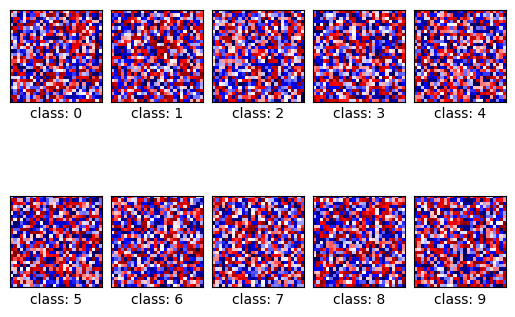

In [39]:
# Visualize the initial parameters (random)
PlotParameters(model)

## Learning rate, criterion, optimizer, data loader

In [40]:
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

## <a name="training" id="training">Training</a>
**May take a few minutes**

In [41]:
n_epochs = 10
loss_list = []
accuracy_list = []
N_test = len(validation_dataset)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
        correct = 0
        # perform a prediction on the validationdata  
        for x_test, y_test in validation_loader:
            z = model(x_test.view(-1, 28 * 28))
            _, y_hat = torch.max(z.data, 1)
            correct += (y_hat == y_test).sum().item()
        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)

In [42]:
train_model(n_epochs)

## <a name="results" id="results">Results</a>

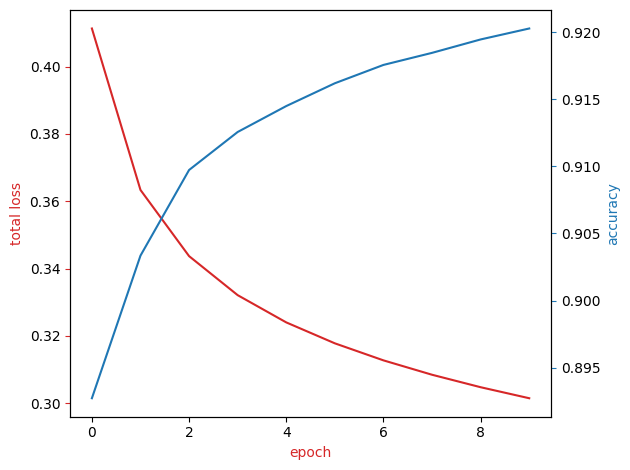

In [43]:
# Plot the loss and accuracy
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

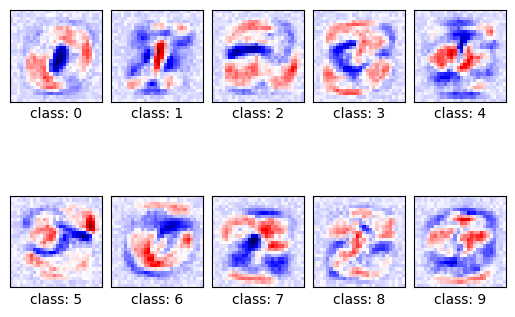

In [44]:
# Visualize final parameters (should approximate numbers)
PlotParameters(model)

### Misclassification examples

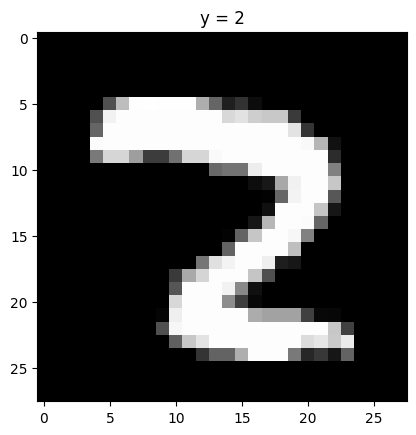

yhat: tensor([7])
probability of class  0.6572877764701843


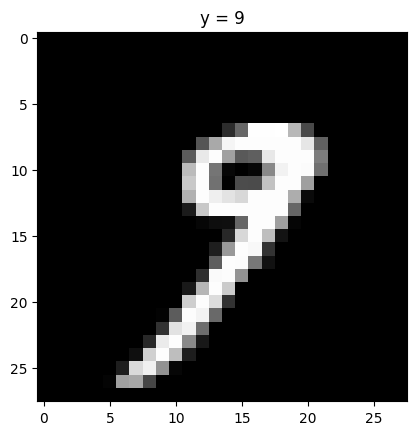

yhat: tensor([7])
probability of class  0.7173988223075867


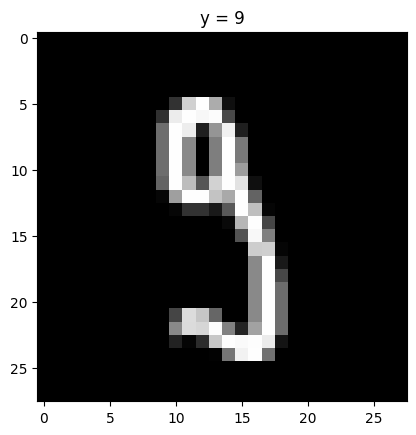

yhat: tensor([5])
probability of class  0.7308847308158875


In [46]:
# Plot the misclassified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 3:
        break       

### Correctly classified examples

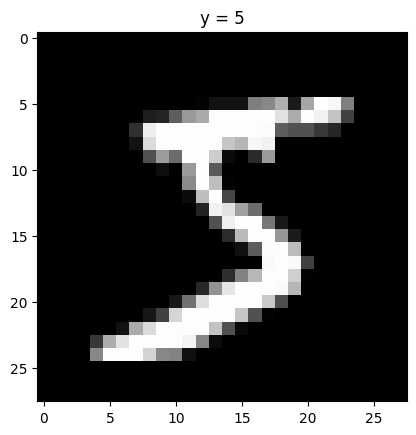

yhat: tensor([5])
probability of class  0.8559899926185608


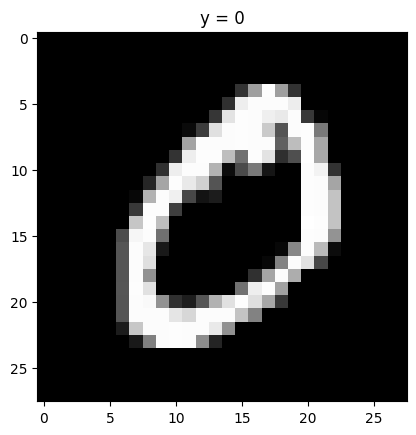

yhat: tensor([0])
probability of class  0.999704897403717


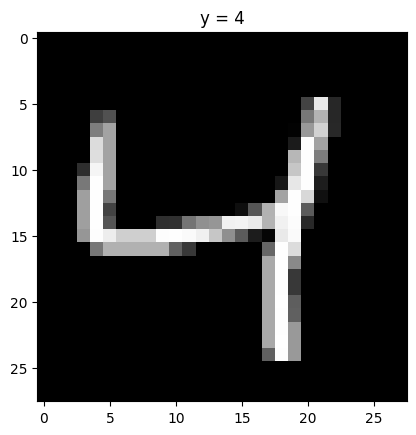

yhat: tensor([4])
probability of class  0.8767179250717163


In [47]:
# Plot the classified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat == y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 3:
        break  